Buckling of a Composite Plate
===

Repreducing results for CASE A, AR1, simply supported from 

    Qiao Jie Yang. "Simplified approaches to buckling of composite plates". Master Thesis. Faculty of Mathematics and Natural Science, University of Oslo, May 2009.
    
See Table 6-1 of the above reference when comparing the results herein obtained.

Plate geometry and laminate data
---

In [29]:
a = 0.5
b = 0.5

E1 = 49.627e9
E2 = 15.43e9
nu12 = 0.38
G12 = 4.8e9
G13 = 4.8e9
G23 = 4.8e9
laminaprop = (E1, E2, nu12, G12, G13, G23)

tmap = {
      45: 0.143e-3,
     -45: 0.143e-3,
       0: 1.714e-3
    }
X = 4
angles = [-45, +45, 0, +45, -45, 0]*X + [0, -45, +45, 0, +45, -45]*X
plyts = [tmap[angle] for angle in angles]


Generating Mesh
---

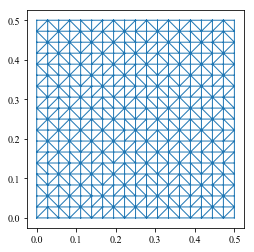

In [30]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

xs = np.linspace(0, a, a // 0.025)
ys = np.linspace(0, b, b // 0.025)
points = np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2)
tri = Delaunay(points)
plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
plt.gca().set_aspect('equal')
plt.show()

Using Meshless Package
---

In [31]:
from scipy.sparse import coo_matrix

from meshless.composite.laminate import read_stack
from meshless.sparse import solve
from meshless.linear_buckling import lb
from meshless.espim.read_mesh import read_delaunay
from meshless.espim.plate2d_calc_k0 import calc_k0
from meshless.espim.plate2d_calc_kG import calc_kG
from meshless.espim.plate2d_add_k0s import add_k0s

mesh = read_delaunay(points, tri)
nodes = np.array(list(mesh.nodes.values()))
prop_from_nodes = True

nodes_xyz = np.array([n.xyz for n in nodes])

**Applying laminate properties**

In [32]:
# applying heterogeneous properties
for node in nodes:
    xyz = node.xyz
    lam = read_stack(angles, plyts=plyts, laminaprop=laminaprop)
    node.prop = lam
print('DEBUG lam.t', node.prop.t)
    

DEBUG lam.t 0.032000000000000015


**Defining Boundary Conditions**


In [33]:
DOF = 5
def bc(K, mesh):
    for node in nodes[nodes_xyz[:, 0] == xs.min()]:
        for dof in [1, 3]:
            j = dof-1
            K[node.index*DOF+j, :] = 0
            K[:, node.index*DOF+j] = 0
    for node in nodes[nodes_xyz[:, 1] == ys.min()]:
        for dof in [2, 3]:
            j = dof-1
            K[node.index*DOF+j, :] = 0
            K[:, node.index*DOF+j] = 0
    for node in nodes[nodes_xyz[:, 1] == ys.max()]:
        for dof in [3]:
            j = dof-1
            K[node.index*DOF+j, :] = 0
            K[:, node.index*DOF+j] = 0
    for node in nodes[nodes_xyz[:, 0] == xs.max()]:
        for dof in [3]:
            j = dof-1
            K[node.index*DOF+j, :] = 0
            K[:, node.index*DOF+j] = 0

**Calculating Constitutive Stiffness Matrix**

In [40]:
#k0s_method = 'edge-based' 
k0s_method = 'cell-based'
#k0s_method = 'cell-based-no-smoothing'
k0 = calc_k0(mesh, prop_from_nodes)
add_k0s(k0, mesh, prop_from_nodes, k0s_method)
bc(k0, mesh)
k0 = coo_matrix(k0)

**Defining Load and External Force Vector**

In [41]:
def define_loads(mesh):
    loads = []
    load_nodes = nodes[(nodes_xyz[:, 0] == xs.max()) &
                       (nodes_xyz[:, 1] != ys.min()) &
                       (nodes_xyz[:, 1] != ys.max())]
    fx = -1. / (nodes[nodes_xyz[:, 0] == xs.max()].shape[0] - 1)
    for node in load_nodes:
        loads.append([node, (fx, 0, 0)])
    load_nodes = nodes[(nodes_xyz[:, 0] == xs.max()) &
                       ((nodes_xyz[:, 1] == ys.min()) |
                        (nodes_xyz[:, 1] == ys.max()))]
    fx = -1. / (nodes[nodes_xyz[:, 0] == xs.max()].shape[0] - 1) / 2
    for node in load_nodes:
        loads.append([node, (fx, 0, 0)])
    return loads
    
n = k0.shape[0] // DOF
fext = np.zeros(n*DOF, dtype=np.float64)
loads = define_loads(mesh)
for node, force_xyz in loads:
    fext[node.index*DOF + 0] = force_xyz[0]
print('Checking sum of forces: %s' % str(fext.reshape(-1, DOF).sum(axis=0)))

Checking sum of forces: [-1.  0.  0.  0.  0.]


**Running Static Analysis**

In [42]:
d = solve(k0, fext, silent=True)
total_trans = (d[0::DOF]**2 + d[1::DOF]**2)**0.5
print('Max total translation', total_trans.max())

Max total translation 7.57008404993e-10


**Calculating Geometric Stiffness Matrix**

In [43]:
kG = calc_kG(d, mesh, prop_from_nodes)
bc(kG, mesh)
kG = coo_matrix(kG)

**Running Linear Buckling Analysis**

In [44]:
eigvals, eigvecs = lb(k0, kG, silent=True)
print('First 5 eigenvalues N/mm')
print('\n'.join(map(str, eigvals[0:5] / b / 1000)))

First 5 eigenvalues N/mm
10567.7403485
21557.4539564
37302.9924955
37892.9734433
47848.9773967


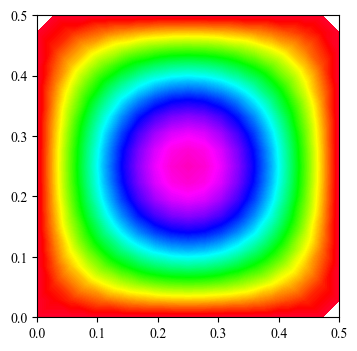

In [45]:
import matplotlib.pyplot as plt
from matplotlib import cm

ind0 = np.array([[n.index, i] for (i, n) in enumerate(nodes)])
ind0 = ind0[np.argsort(ind0[:, 0])]
nodes_in_k0 = nodes[ind0[:, 1]]
xyz = np.array([n.xyz for n in nodes_in_k0])
ind = np.lexsort((xyz[:, 1], xyz[:, 0]))
w = eigvecs[:, 0][2::DOF][ind]
xyz = xyz[ind]
plt.figure(dpi=100)
levels = np.linspace(w.min(), w.max(), 400)
plt.tricontourf(xyz[:, 0], xyz[:, 1], w, levels=levels, cmap=cm.gist_rainbow_r)
plt.gca().set_aspect('equal')
plt.show()